# Forecast Hybrid Production Notebook
Author: George Panagiotou

In [2]:
import pandas as pd
import numpy as np
from comp_utils import *
import xgboost as xgb
import os
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import KFold

## Test and train data:

Load the test and train data, which have already been preprocessed in a different notebook

In [3]:
Solar = pd.read_hdf('data/reference_time_06/SolarTrainTable.h5', 'df')
Wind = pd.read_hdf('data/reference_time_06/WindTrainTable.h5', 'df')
merged_df = pd.merge(Solar, Wind, on='valid_time', how='outer')


train_table = pd.merge(Solar, Wind, on='valid_time', how='outer')
train_table = train_table.dropna()

train_table['total_generation_MWh'] = train_table['Wind_MWh_credit'] + train_table['Solar_MWh_credit']
train_target_variable = train_table['total_generation_MWh']

print('Train features before removing columns:', train_table.shape)

train_times = train_table['valid_time']
train_table = train_table.drop(['total_generation_MWh','Solar_MWh_credit','Wind_MWh_credit','Solar_capacity_mwp'], axis=1)

print('Train features after removing columns:', train_table.shape)

Train features before removing columns: (56284, 165)
Train features after removing columns: (56284, 161)


In [4]:
Solar = pd.read_hdf('data/reference_time_06/SolarTestTable.h5', 'df')
Wind = pd.read_hdf('data/reference_time_06/WindTestTable.h5', 'df')
merged_df = pd.merge(Solar, Wind, on='valid_time', how='outer')


test_table = pd.merge(Solar, Wind, on='valid_time', how='outer')
test_table['total_generation_MWh'] = test_table['Wind_MWh_credit'] + test_table['Solar_MWh_credit']
test_target_variable = test_table['total_generation_MWh']

print('Train features before removing columns:', test_table.shape)

test_times = test_table['valid_time']
test_table = test_table.drop(['total_generation_MWh','Solar_MWh_credit','Wind_MWh_credit','Solar_capacity_mwp'], axis=1)

print('Train features after removing columns:', test_table.shape)

Train features before removing columns: (4318, 165)
Train features after removing columns: (4318, 161)


## Transforming time into cyclic features:


In [5]:
train_table = add_cyclic_features(train_table)
train_table = train_table.drop(columns=["valid_time"])
print('Train features after adding cyclic times and removing valid_time:', train_table.shape)

test_table = add_cyclic_features(test_table)
test_table = test_table.drop(columns=["valid_time"])
print('Test features after adding cyclic times and removing valid_time:', test_table.shape)

Train features after adding cyclic times and removing valid_time: (56284, 169)
Test features after adding cyclic times and removing valid_time: (4318, 169)


### XGBRegressor (Tuning)
!!! DO NOT RUN !!!

In [9]:
# Define parameter search space
search_spaces = {
    'learning_rate': Real(0.01, 0.2, 'uniform'),
    'max_depth': Integer(1, 20), 
    'n_estimators': Integer(100, 500), 
}
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_models = {}

# Pinball loss function
def pinball_loss(y_true, y_pred, alpha):
    residuals = y_true - y_pred
    return np.mean(np.maximum(alpha * residuals, (alpha - 1) * residuals))

# Bayesian optimization search for each quantile
for quantile in quantiles:
    print(f"Running Bayesian optimization search for the {quantile * 100}% quantile.")
    model = xgb.XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=quantile,
        tree_method='hist',
        verbosity=0
    )

    custom_scorer = make_scorer(pinball_loss, greater_is_better=False, alpha=quantile)
    kf = KFold(n_splits=5) 
    
    optimizer = BayesSearchCV(
        estimator=model,
        search_spaces=search_spaces,
        n_iter=16,  
        cv=kf,  
        scoring=custom_scorer,
        verbose=1,
        n_jobs=-1,
        return_train_score=True
    )
    optimizer.fit(train_table, train_target_variable)
    best_model = optimizer.best_estimator_

    model_path = f'models/ExtremeGB/XGBR_BEST_q{int(quantile * 100)}.json'
    best_model.save_model(model_path) 

    print(f"Best parameters for {quantile * 100}% quantile: {optimizer.best_params_}")
    best_models[f'q{int(quantile*100)}'] = best_model

    # Retrieve and print CV error for the optimal model
    mean_test_score = optimizer.cv_results_['mean_test_score'][optimizer.best_index_]
    mean_train_score = optimizer.cv_results_['mean_train_score'][optimizer.best_index_]
    print(f"CV error for {quantile * 100}% quantile: {mean_test_score}")
    print(f"Training error for {quantile * 100}% quantile: {mean_train_score}")

print("Optimization complete. Best models saved.")

Running Bayesian optimization search for the 10.0% quantile.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

## Train set:


In [6]:
quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = train_target_variable

quantiles = range(10, 100, 10)
dtrain = xgb.DMatrix(train_table)

for qu in quantiles:
    model_path = f'models/ExtremeGB/XGBR_BEST_q{qu}.json'
    model = xgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(dtrain)

quantile_predictions_df = pd.DataFrame(quantile_predictions)

# The following 2 lines is to remove any non positive values from the data sets. 
# Some of the prediction when all quantiles are close to zero are predicting negative values. 
# Ensure no negative predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))

# Sort quantiles, avoid cross overs between them 
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)

# Training loss
print('Training Loss(Quantile):',pinball_score(quantile_predictions_df,target_col='total_generation_MWh'))

# Save the predictions (They might be used for ensemble learning)
quantile_predictions_df['time'] = train_times  
csv_file_path = 'data/ExtremeGB/Hybrid_quantiles_train_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

Training Loss(Quantile): 22.02477947053519


## Test set

In [7]:
quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = test_target_variable

quantiles = range(10, 100, 10)
dtest = xgb.DMatrix(test_table)

for qu in quantiles:
    model_path = f'models/ExtremeGB/XGBR_BEST_q{qu}.json'
    model = xgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(dtest)

# Ensure no negative predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))

# Sort quantiles, avoid cross overs between them 
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)

# Test loss
print('Test Loss(Quantile)',pinball_score(quantile_predictions_df,target_col='total_generation_MWh'))

# Save the predictions (They might be used for ensemble learning)
quantile_predictions_df['time'] = test_times  
csv_file_path = 'data/ExtremeGB/Hybrid_quantiles_test_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

Test Loss(Quantile) 24.517594558973254


In [8]:
save_path = "plots/ExtremeGB/XGBR_Best_plot_Quantiles.html"
graph_title = "Hybrid Production Forecast (XGBR-1)"
quantile_predictions_df['time'] = test_times 
plot_quantiles_target_and_average_loss_interactive(quantile_predictions_df, 'total_generation_MWh', test_times,  save_path, title=graph_title)

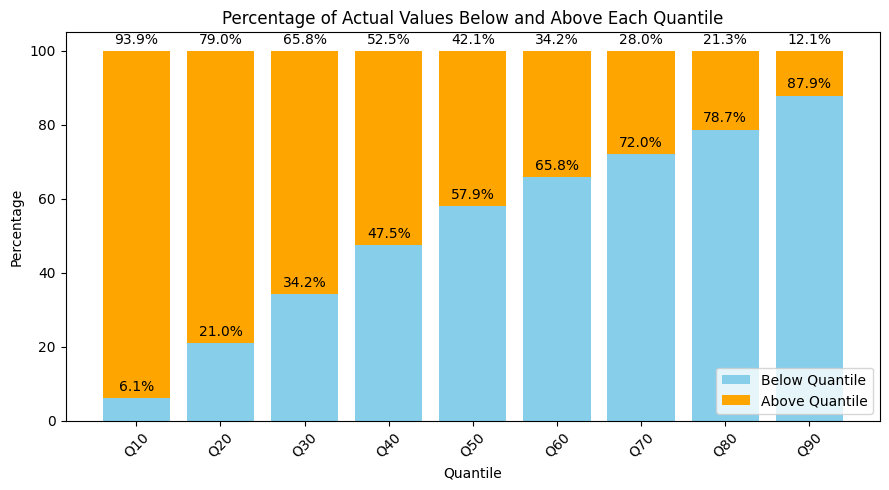

In [9]:
quantile_stats(quantile_predictions_df)

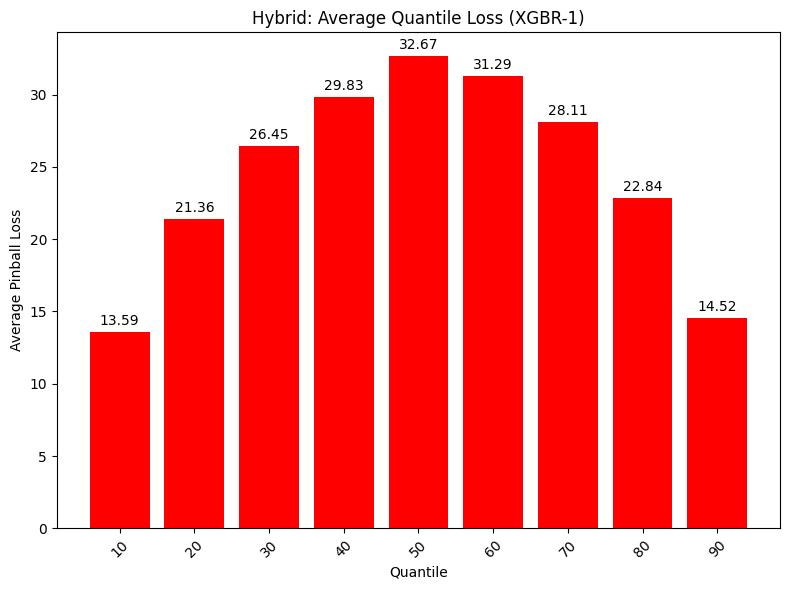

In [10]:
calculate_and_plot_average_quantile_loss(quantile_predictions_df, 'total_generation_MWh', "Hybrid: Average Quantile Loss (XGBR-1)")